In [123]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

#import autoreload  (for debugging external subroutines)
%load_ext autoreload
%autoreload 2

# subroutines needed, we also need kepcart.py
from orbsubs import *  
from outils import *
from scipy.signal import savgol_filter 
from scipy.ndimage import median_filter 

plt.rcParams.update({'font.size': 14})

# this file has current figures for a paper!


import pymesh
#https://pymesh.readthedocs.io/en/latest/basic.html
# https://github.com/PyMesh/PyMesh

import meshplot
# for display of meshes
#https://skoch9.github.io/meshplot/tutorial/

import random

# nicer plots
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14


#https://quaternion.readthedocs.io/en/latest/
import quaternion

from byorp_subs import *
# my subroutines are moved here

# shape models available here:
#https://www.naic.edu/~smarshal/1999kw4.html
#Squannit is secondary of Moshup which was 1999KW4



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Binary simulation output plotting and doing BYORP with output of simulation 

In [16]:
# plot some stuff
def mkplot(tarr,aaarr,eearr,iiarr,lnarr,ararr,maarr,om1,om2,\
        lobliquity_deg1,lobliquity_deg2,sobliquity_deg2,meanmotion,\
        lib_angle2,lprec_ang2,sprec_ang2,nprec_ang2,phi1,phi2,theta_B,\
           theta_k,theta2_NPA,ntilt2,longtilt2\
           ,froot,dn,tmin,tmax,ofilename):
    # dn is to plot every other point
    nvpanels = 10
    f,axarr =  plt.subplots(nvpanels,1, dpi=200, figsize=(6,10), sharex=True)
    plt.autoscale(enable=True, axis='x', tight=True)
    plt.subplots_adjust(left=0.23, right=0.96, top=0.99, bottom=0.10, \
        wspace=0.22, hspace=0.0)
    
    Porb_init = 2*np.pi/meanmotion[0]
    print('Porb {:.2f}'.format(Porb_init))
    tarrp = tarr/Porb_init
    i0 = 0
    i1 = len(om1)
    if (tmax >0):
        i0 = np.argmin(np.abs(tarrp-tmin))
        i1 = np.argmin(np.abs(tarrp-tmax))
        tarrp -= tmin
        axarr[0].set_xlim([0,tmax-tmin])
        
    
    ###########################
    il = 0;   # top
    axarr[il].set_ylabel('spin')
    smax = np.amax([np.amax(om1[i0:i1]),np.amax(om2[i0:i1])])
    smin = np.amin([np.amin(om1[i0:i1]),np.amin(om2[i0:i1])])
    axarr[il].set_ylim(smin,smax)
    axarr[il].plot(tarrp[i0:i1:dn],om1[i0:i1:dn],'.',color='greenyellow',\
                   ms=2,label=r'$\omega_p$')
    axarr[il].plot(tarrp[i0:i1:dn],om2[i0:i1:dn],'.',color='blue',alpha=0.5,\
                   ms=2,label=r'$\omega_s$')
    mm_smo = meanmotion
    if (len(tarr)>100):
        mm_smo = savgol_filter(meanmotion, 21, 2, mode='nearest')
    axarr[il].plot(tarrp[::dn],mm_smo[::dn]*1,':',color='brown',lw=2,alpha=0.5)
    axarr[il].plot(tarrp[::dn],mm_smo[::dn]*1,':',color='mistyrose',lw=1,alpha=1)
    for j in range(2,7):
        axarr[il].plot(tarrp[i0:i1:dn],mm_smo[i0:i1:dn]*j,':',color='brown',lw=1,alpha=0.5)
    #for j in range(0,7):
    #    axarr[il].plot(tarr[::dn],mm_smo[::dn]*(j+0.5),':',color='purple',lw=1,alpha=0.5)
    axarr[il].legend(borderpad=0.1,labelspacing=0.1,handlelength=0.5,handletextpad=0.1,\
                    markerscale=2,loc='upper right')
    
    ##########################
    il += 1;
    axarr[il].set_ylabel('obliquity')
    axarr[il].plot(tarrp[i0:i1:dn],lobliquity_deg1[i0:i1:dn],'.',color='red',\
                   ms=1,label=r'$\epsilon_p$')
    #axarr[il].plot(tarr[::dn],sobliquity_deg2[::dn],'.',color='orange',\
    #               ms=1,label='sec')
    axarr[il].plot(tarrp[i0:i1:dn],lobliquity_deg2[i0:i1:dn],'.',color='darkorange',\
                   ms=1,label=r'$\epsilon_s$',alpha=0.6)
    axarr[il].legend(borderpad=0.1,labelspacing=0.1,handlelength=0.5,handletextpad=0.1,\
                    markerscale=2)
    
    ##########################
    il += 1;
    axarr[il].set_ylabel('libration\n angle')
    lib_a = lib_angle2%np.pi
    ii = (lib_a > np.pi/2)
    lib_a[ii] -= np.pi
    lib_a *= 180.0/np.pi
    axarr[il].plot(tarrp[i0:i1:dn],lib_a[i0:i1:dn],'.',color='purple',ms=2,alpha=0.6,\
                   label=r'$\phi_{lib,s}$')

    axarr[il].legend(borderpad=0.1,labelspacing=0.1,handlelength=0.5,handletextpad=0.1,\
                    markerscale=2,loc='lower right')
    #axarr[il].set_ylim(bottom=2.5,top=5)
    
    
    ##########################
    il += 1;
    axarr[il].set_ylabel('long\n axis inc.')
    axarr[il].plot(tarrp[i0:i1:dn],longtilt2[i0:i1:dn]*180/np.pi,'.',color='gray',ms=2,\
                   label=r'inclination of $\hat {\bf i}_s$',alpha=0.5)
    axarr[il].legend(borderpad=0.1,labelspacing=0.1,handlelength=0.5,handletextpad=0.1,\
                    markerscale=2,loc='upper right')
    
    ##########################
    il += 1;
    axarr[il].set_ylabel('NPA\n angle')
    axarr[il].plot(tarrp[i0:i1:dn],theta2_NPA[i0:i1:dn]*180/np.pi,'.',color='orchid',ms=2,\
                   label=r'$\theta_{NPA,s}$',alpha=0.6)
    
    axarr[il].legend(borderpad=0.1,labelspacing=0.1,handlelength=0.5,handletextpad=0.1,\
                    markerscale=2,loc='upper left')
    
    
    ##########################
    il += 1;
    axarr[il].set_ylabel('short\n axis tilt')
    axarr[il].plot(tarrp[i0:i1:dn],ntilt2[i0:i1:dn]*180/np.pi,'.',color='deepskyblue',\
                   ms=1,label=r'acos $|\hat {\bf k}_s \cdot \hat {\bf l}_B|$',alpha=0.6)
    axarr[il].legend(borderpad=0.1,labelspacing=0.1,handlelength=0.5,handletextpad=0.1,\
                    markerscale=2,loc='upper left')
    
    ##########################
    il += 1;
    axarr[il].set_ylabel(r'precession')
    res_ang = (lprec_ang2 - theta_B)%np.pi  # spin angular momentum precession angle
    res_ang2 = (nprec_ang2 - theta_B)%np.pi  # short axis precession angle
    axarr[il].plot(tarrp[::dn],res_ang[::dn]*180.0/np.pi,'.',color='peru',ms=2,\
                   label=r'$\theta_{ls} - \theta_B$',alpha=0.5)
    #axarr[il].plot(tarrp[::dn],res_ang2[::dn]*180.0/np.pi,'.',color='gold',ms=2,\
    #               label=r'$\theta_{ks} - \theta_B$',alpha=0.5)
    # winds up at 90degrees
    axarr[il].legend(borderpad=0.1,labelspacing=0.1,handlelength=0.5,handletextpad=0.1,\
                    markerscale=2,loc='upper left')
    
    ##########################
    il += 1;
    axarr[il].set_ylabel('res.\n ang')
    #res_ang = (2*phi2 - 2*theta_B + theta_k)%np.pi
    res_ang2 = (2*lib_angle2 + theta_k)%np.pi
    #axarr[il].plot(tarrp[i0:i1:dn],res_ang[i0:i1:dn]*180/np.pi,'.',color='green',ms=2,\
    #               label=r'$2(\phi_2- \theta_B) + \theta_{kB}$',alpha=0.5)
    axarr[il].plot(tarrp[i0:i1:dn],res_ang2[i0:i1:dn]*180/np.pi,'.',color='orangered',ms=2,\
                   label=r'$2 \phi_{lib,s} + \theta_{kB}$',alpha=0.5)
    axarr[il].legend(borderpad=0.1,labelspacing=0.1,handlelength=0.5,handletextpad=0.1,\
                    markerscale=2,loc='upper left')
    
    
    ##########################
    il += 1;
    axarr[il].set_ylabel(r'$a_B/R_p$')
    amax = max(aaarr[i0:i1])
    amin = min(aaarr[i0:i1])
    if (amax > 5):
        axarr[il].set_ylim(max(amin,0),5)
    axarr[il].plot(tarrp[i0:i1:dn],aaarr[i0:i1:dn],'.',color='green',ms=2,alpha=0.6)
    
    #axarr[il].set_ylim(bottom=2.5,top=5)
    
    ########################## 
    il += 1;
    axarr[il].set_ylabel(r'$e_B, i_B$')
    emax = max(eearr)
    #emin = 0
    if (emax > 1):
        axarr[il].set_ylim(0,1)
    
    axarr[il].plot(tarrp[i0:i1:dn],eearr[i0:i1:dn],'.',color='dodgerblue',ms=2,label=r'$e_B$',alpha=0.6)
    axarr[il].plot(tarrp[i0:i1:dn],iiarr[i0:i1:dn],'.',color='red',ms=1,label=r'$i_B$',alpha=0.3)
    axarr[il].legend(borderpad=0.1,labelspacing=0.1,handlelength=0.5,handletextpad=0.1,\
                    markerscale=2,loc='upper left')
    
    
    ########################## 
    
    il = nvpanels-1;
    axarr[il].set_xlabel('time (orbital periods)')
    if (len(ofilename)>3):
        plt.savefig(ofilename)

In [109]:
# compute the BYORP torque, for a tidally locked binary using simulation output
# arguments:
#   body: vertices, faces triangular surface mesh (in principal axis coordinate system)
#   tarr: time array
#   s_hat_arr: array of solar orientations
#   qarr: array of quaternions to rotate body
#   a_bin: array of binary directions
#   l_bin: orbit normal (not an array)
# returns:
#   torque dot l_bin so can compute binary orbit drift rate
def compute_BY_orbit(vertices,faces,tarr,s_hat_arr,qarr,a_bin_arr,l_bin):
    tau_l_arr = np.zeros(len(s_hat_arr))
    
    for i in range(len(s_hat_arr)):
        q = qarr[i]  # quaternion specifying body direction 
        a_x = a_bin_arr[i,0]  # binary direction
        a_y = a_bin_arr[i,1]
        a_z = a_bin_arr[i,2]
        s_hat = np.squeeze(s_hat_arr[i,:]) # solar direction vector
        # rotate the body!
        tvertices =quaternion.rotate_vectors(q, vertices) 
        f_areas, f_normals = face_areas(tvertices,faces) # vector of facet areas and face normal vectors
        F_i_x,F_i_y,F_i_z = F_i(f_areas,f_normals,s_hat)   # forces of each facet 
        F_x = np.sum(F_i_x); F_y = np.sum(F_i_y); F_z = np.sum(F_i_z);  # sum forces 
        tau_x,tau_y,tau_z = cross_prod_xyz(a_x,a_y,a_z,F_x,F_y,F_z) # cross product
        #gives instantaneous BYORP torque
        tau_l = tau_x*l_bin[0] + tau_y*l_bin[1] + tau_z*l_bin[2]   # component along orbit normal
        #print(tau_l)
        tau_l_arr[i] = tau_l
        
    return tau_l_arr
 

In [17]:
# global information needed!
simdir = "../bin5/" # where simulation output files are found  
m1 = 1.0;  # masses of the two bodies!  Globals!
m2 = 0.01;  #  lower mass secondary
GM = m1+m2 # G=1

In [18]:
froot = 'b1'  # seed=4
ofilename=''  
tmax=-1;tmin=0; print(4e5/32.49)  # t in P_B

12311.480455524776


../bin5/b1_ext_1.txt
../bin5/b1_ext_2.txt
Porb 32.49


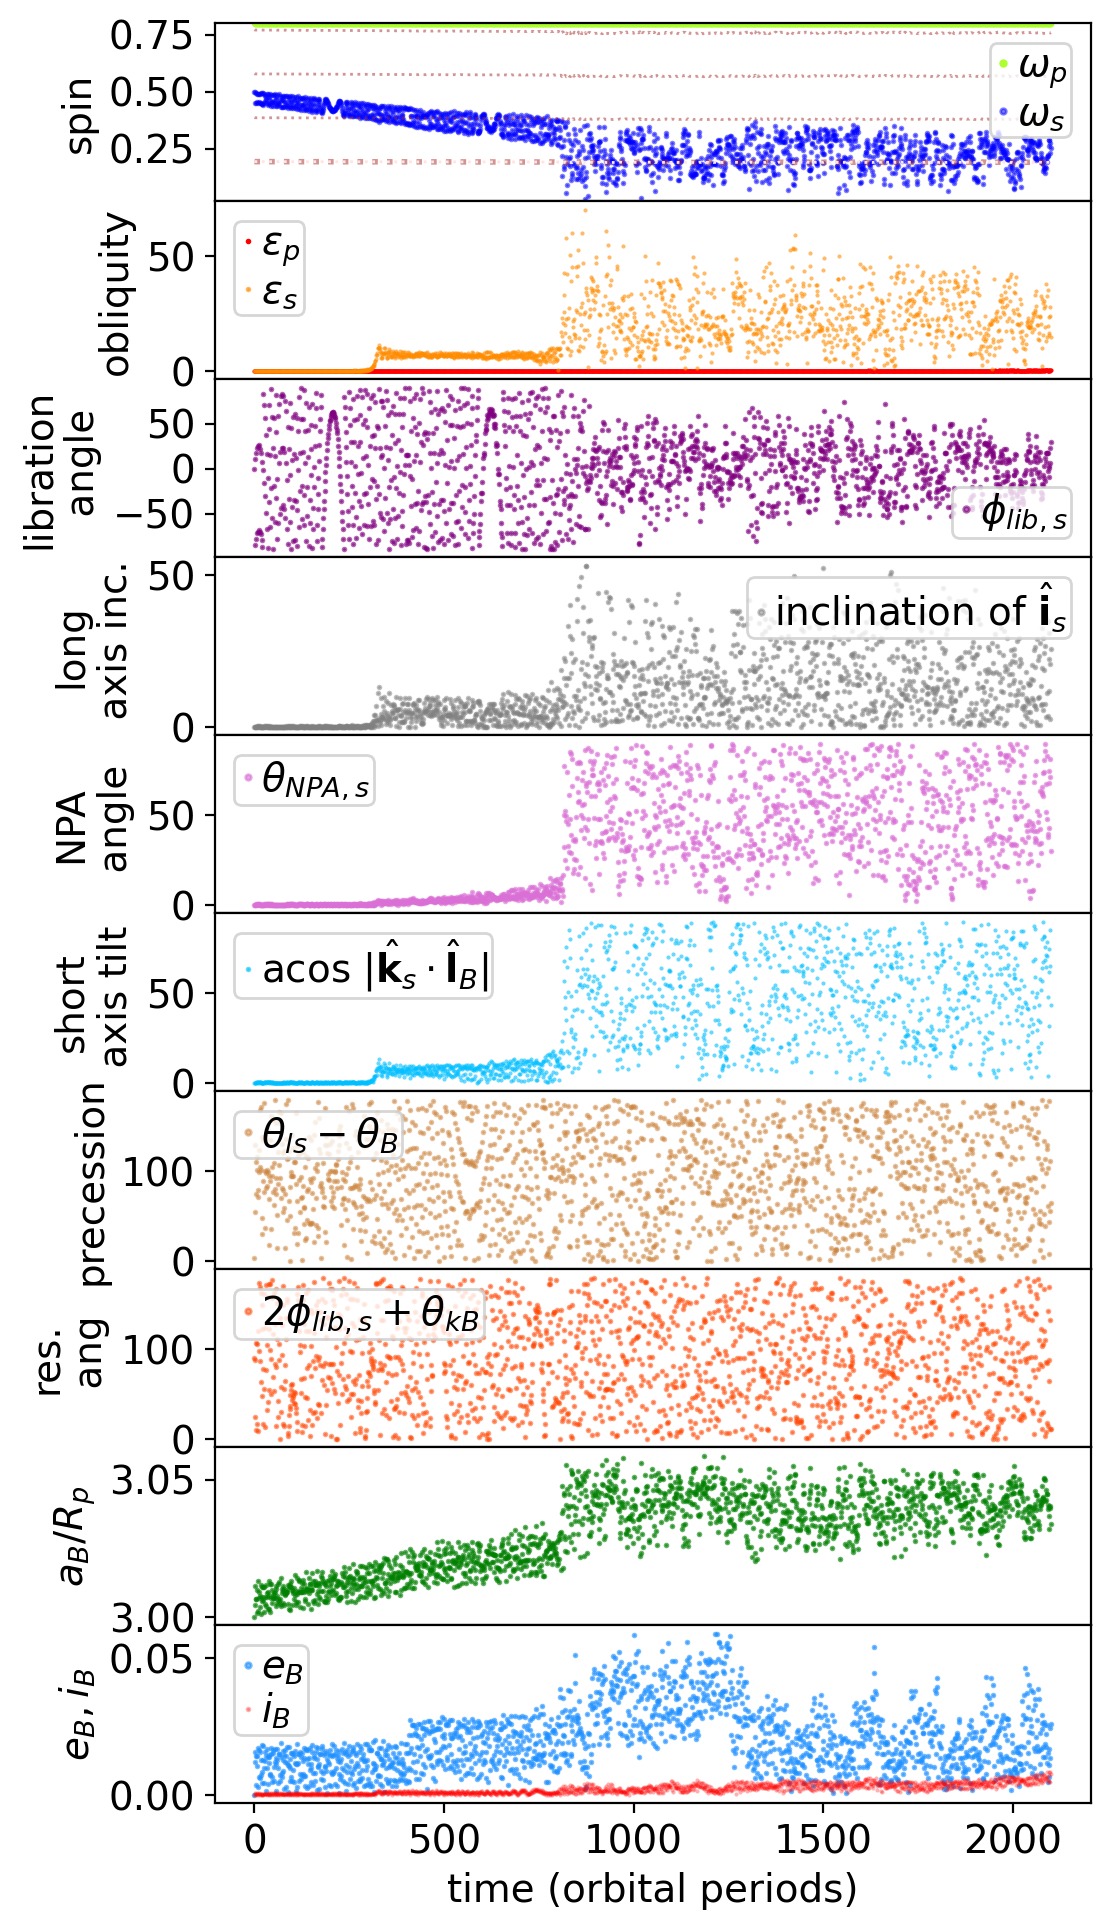

In [146]:
tarr,aaarr,eearr,iiarr,lnarr,ararr,maarr,om1,om2,\
        lobliquity_deg1,lobliquity_deg2,sobliquity_deg2,meanmotion,\
        lib_angle2,lprec_ang2,sprec_ang2,nprec_ang2,phi1,phi2,theta_B,theta_k,theta2_NPA,ntilt2,longtilt2\
        = read_two_bodies(simdir,froot,GM)
mkplot(tarr,aaarr,eearr,iiarr,lnarr,ararr,maarr,om1,om2,\
        lobliquity_deg1,lobliquity_deg2,sobliquity_deg2,meanmotion,\
       lib_angle2,lprec_ang2,sprec_ang2,nprec_ang2,phi1,phi2,theta_B,\
       theta_k,theta2_NPA,ntilt2,longtilt2\
       ,froot,20,tmin,tmax,ofilename)

In [147]:
# read in covariance matrix
t,C_xx,C_xy,C_xz,C_yx,C_yy,C_yz,C_zx,C_zy,C_zz = readcovarfile(simdir+froot,1)
# make an array of quaternions one per timestep of the simulation output
qarr = quatrot_vec(C_xx,C_xy,C_xz,C_yx,C_yy,C_yz,C_zx,C_zy,C_zz)
# we will rotate the original body by qarr to get the current orientation of the body
qarr=qarr[0:len(tarr)]  # to make sure vectors are the same length as regular simulation output

# get orbital period
P_orb = 2*np.pi/meanmotion[0]
print('Orbital period {:.1f}'.format(P_orb))
# how many orbital periods do we have right now?
print('tmax = {:.2e} tmax/P = {:.2f}'.format(max(tarr), max(tarr/P_orb)))

Orbital period 32.5
tmax = 6.83e+04 tmax/P = 2101.13


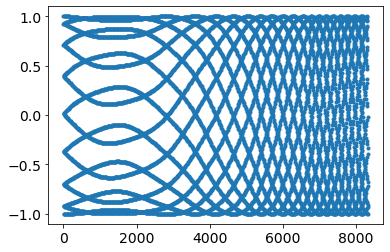

In [148]:
# make a vector of binary directions and the binary orbit normal
def mkbin(tarr,theta_B):
    a_bin = np.zeros((len(tarr),3))
    a_bin[:,0] = np.cos(theta_B)
    a_bin[:,1] = np.sin(theta_B)
    a_bin[:,2] = 0.0 # unit vector to binary
    l_bin = np.array([0,0,1])  # orbit normal (approximately)
    return a_bin,l_bin 

abin_arr,l_bin = mkbin(tarr,theta_B)
plt.plot(a_bin[:,0],'.') # looks ok

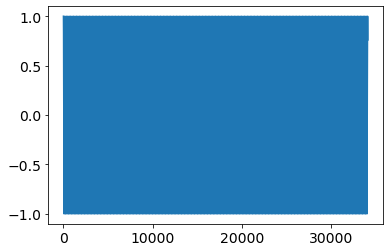

In [149]:
# make array of solar directions 
#   tarr is time array
#   incl is solar orbit inclination , not used yet
#   omega_sun is how fast Sun advances on the sky
def mk_s_hat(tarr,incl,omega_Sun):
    phi_Sun = omega_Sun*tarr%(2*np.pi)  # how phi of sun advances
    s_hat_arr = np.zeros((len(tarr),3))
    s_hat_arr[:,0] = np.cos(phi_Sun)
    s_hat_arr[:,1] = np.sin(-phi_Sun) # go backwards to pretend we are at high inclination
    #s_hat_arr[:,2] = 0.0 not necessary because array has zeros in it
    return s_hat_arr

# an orbit is Porb=32.49 and there should be about 1000 in a year (365*2)
P_sun = 10*P_orb  # making this shorter so that we have a number of periods right now
omega_Sun = 2.0*np.pi/P_sun
incl=0; 
s_hat_arr = mk_s_hat(tarr,incl,omega_Sun)
plt.plot(s_hat_arr[:,0])  # a few periods in output so far

In [150]:
# make some meshes
center = np.array([0,0,0])
sphere = pymesh.generate_icosphere(1., center, refinement_order=2)
# create a perturbed ellipsoid using the above sphere
devrand = 0.05  # perturbation size  # fiducial model
aratio1 = 0.5   # axis ratios c/a
aratio2 = 0.7   # b/a
random.seed(2)  # fix the sequence
psphere1 = sphere_perturb(sphere,devrand,1,1)  #perturbed sphere 
body1 = body_stretch(psphere1,aratio1,aratio2)  # stretch so is an ellipsoid

In [151]:
# compute the BYORP torque for a sphere, takes a while
tau_l_s=compute_BY_orbit(sphere.vertices,sphere.faces,tarr,s_hat_arr,qarr,abin_arr,l_bin)

In [152]:
# compute the BYORP torque for an ellipsoid, takes a while
tau_l_b1=compute_BY_orbit(body1.vertices,body1.faces,tarr,s_hat_arr,qarr,abin_arr,l_bin)

In [153]:
tau_l_s_smo = median_filter(tau_l_s, size=400, mode='constant')
tau_l_s_smos = savgol_filter(tau_l_s, 401, 2)
tau_l_b1_smo = median_filter(tau_l_b1, size=400, mode='constant')
tau_l_b1_smos = savgol_filter(tau_l_b1, 401, 2)

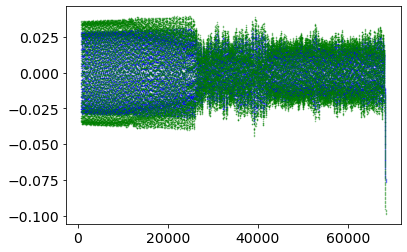

In [155]:
#plt.plot(tarr,tau_l_s,'b.',ms=0.5,alpha=0.5)
#plt.plot(tarr,tau_l_b1,'r.',ms=1,alpha=0.5)

#plt.plot(tarr,tau_l_b1_smo,'b.',ms=1,alpha=0.5)
#plt.plot(tarr,tau_l_s_smo,'g.',ms=1,alpha=0.5)
i0 =400
plt.plot(tarr[i0:],tau_l_b1_smos[i0:],'b.',ms=1,alpha=0.5)
plt.plot(tarr[i0:],tau_l_s_smos[i0:],'g.',ms=1,alpha=0.5)

In [ ]:
# they look the same